In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, morphology, measure
from scipy import ndimage
import os

## 1. Load and Display Image

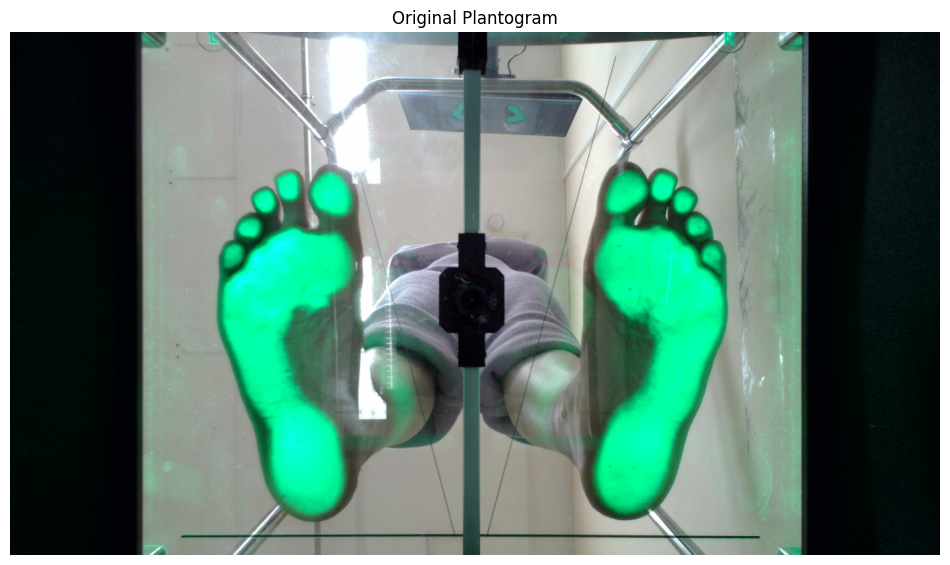

Image shape: (1080, 1920, 3)


In [2]:
# Load plantogram image
image_path = "/home/dima/Documents/альбрехт/обработка изображений/плантограммы/Img (copy 7).png"
image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title("Original Plantogram")
plt.axis('off')
plt.show()

print(f"Image shape: {image.shape}")

## 2. Segmentation Methods

### Option A: HSV-based Segmentation
Works well when foot has distinct color from background

/tmp/ipykernel_206654/1019652837.py:20: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = morphology.remove_small_objects(mask, min_size=1000)
/tmp/ipykernel_206654/1019652837.py:21: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = morphology.remove_small_holes(mask, area_threshold=500)
/tmp/ipykernel_

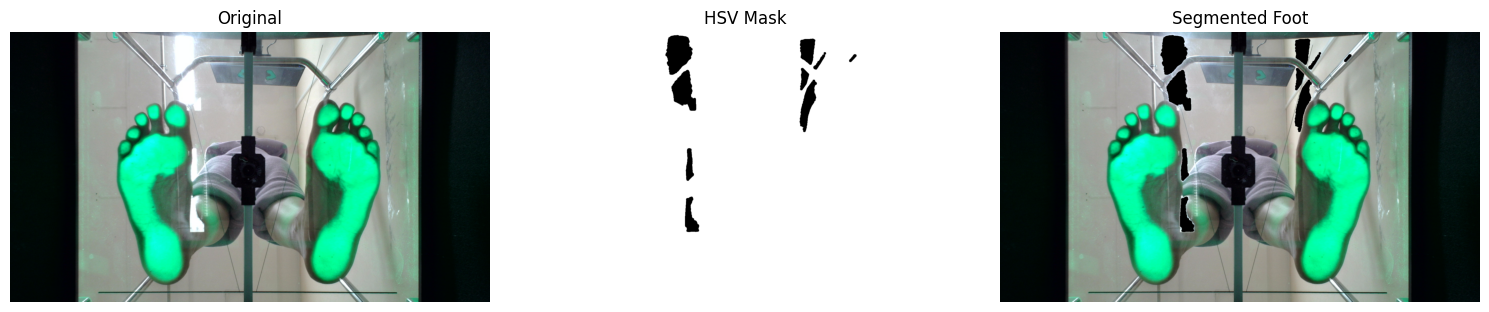

In [3]:
def segment_foot_hsv(image_rgb, sat_threshold=0.1, val_threshold=0.9):
    """
    Segment foot using HSV color space.
    Foot typically has higher saturation and lower value than white/gray background.
    
    Parameters:
    - sat_threshold: minimum saturation for foot pixels
    - val_threshold: maximum value for foot pixels (to exclude bright background)
    """
    hsv = color.rgb2hsv(image_rgb)
    
    # Foot typically has some color (saturation > 0) and isn't pure white
    saturation = hsv[:, :, 1]
    value = hsv[:, :, 2]
    
    # Create mask: foot has saturation OR isn't too bright
    mask = (saturation > sat_threshold) | (value < val_threshold)
    
    # Clean up mask with morphological operations
    mask = morphology.remove_small_objects(mask, min_size=1000)
    mask = morphology.remove_small_holes(mask, area_threshold=500)
    mask = morphology.binary_closing(mask, morphology.disk(5))
    
    return mask.astype(np.uint8)

# Try HSV segmentation
mask_hsv = segment_foot_hsv(image_rgb)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb)
axes[0].set_title("Original")
axes[1].imshow(mask_hsv, cmap='gray')
axes[1].set_title("HSV Mask")
axes[2].imshow(image_rgb * mask_hsv[:,:,np.newaxis])
axes[2].set_title("Segmented Foot")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Option B: Otsu Thresholding
Simple and automatic threshold selection

Otsu threshold value: 90.0


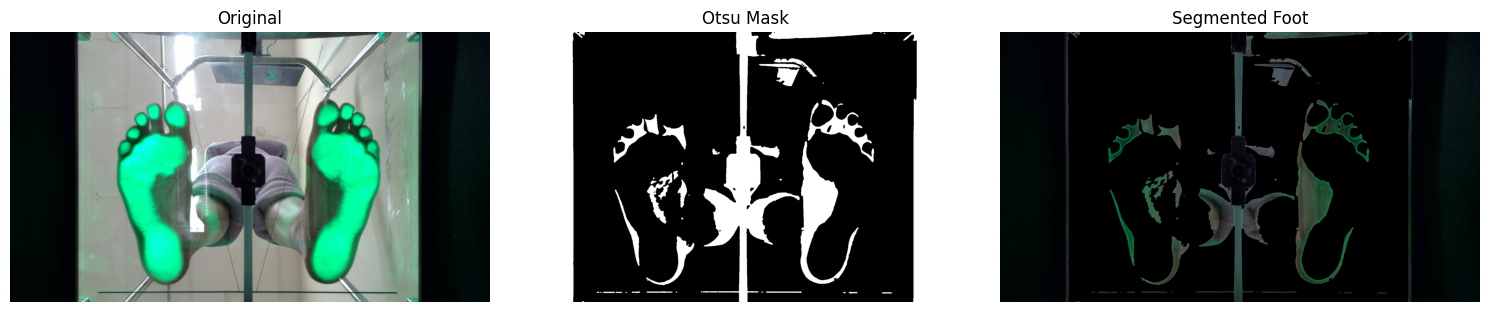

In [4]:
def segment_foot_otsu(image_rgb):
    """
    Segment foot using Otsu's automatic thresholding on grayscale.
    """
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    
    # Otsu's thresholding
    thresh_val, mask = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    print(f"Otsu threshold value: {thresh_val}")
    
    # Morphological cleanup
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    
    return (mask > 0).astype(np.uint8)

mask_otsu = segment_foot_otsu(image_rgb)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb)
axes[0].set_title("Original")
axes[1].imshow(mask_otsu, cmap='gray')
axes[1].set_title("Otsu Mask")
axes[2].imshow(image_rgb * mask_otsu[:,:,np.newaxis])
axes[2].set_title("Segmented Foot")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Split Left and Right Foot

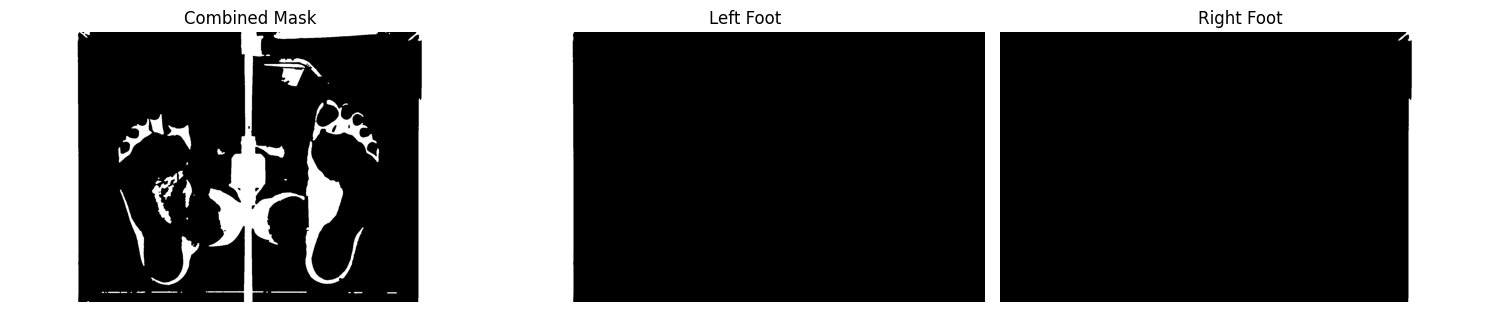

In [5]:
def split_feet(mask):
    """
    Split the mask into left and right foot regions.
    Returns separate masks for each foot.
    """
    # Label connected components
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)
    
    # Sort regions by size (largest first)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)
    
    if len(regions) >= 2:
        # Get the two largest regions (should be the two feet)
        foot1 = (labeled == regions[0].label).astype(np.uint8)
        foot2 = (labeled == regions[1].label).astype(np.uint8)
        
        # Determine left/right based on centroid x-coordinate
        centroid1_x = regions[0].centroid[1]
        centroid2_x = regions[1].centroid[1]
        
        if centroid1_x < centroid2_x:
            return foot1, foot2  # foot1 is left, foot2 is right
        else:
            return foot2, foot1  # foot2 is left, foot1 is right
    elif len(regions) == 1:
        # Only one foot detected
        single_foot = (labeled == regions[0].label).astype(np.uint8)
        return single_foot, None
    else:
        return None, None

# Use the better segmentation result
mask = mask_otsu  # or mask_hsv, depending on which works better
left_foot_mask, right_foot_mask = split_feet(mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title("Combined Mask")
if left_foot_mask is not None:
    axes[1].imshow(left_foot_mask, cmap='gray')
    axes[1].set_title("Left Foot")
if right_foot_mask is not None:
    axes[2].imshow(right_foot_mask, cmap='gray')
    axes[2].set_title("Right Foot")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Calculate Foot Measurements

In [6]:
def calculate_foot_measurements(foot_mask, pixels_per_mm=None):
    """
    Calculate basic foot measurements from a binary mask.
    
    Parameters:
    - foot_mask: binary mask of single foot
    - pixels_per_mm: calibration factor (if known)
    
    Returns:
    - dict with measurements in pixels (and mm if calibrated)
    """
    if foot_mask is None or foot_mask.sum() == 0:
        return None
    
    # Find contours
    contours, _ = cv.findContours(foot_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    
    # Get the largest contour (main foot outline)
    contour = max(contours, key=cv.contourArea)
    
    # Bounding box
    x, y, w, h = cv.boundingRect(contour)
    
    # Minimum area rotated rectangle (oriented bounding box)
    rect = cv.minAreaRect(contour)
    (cx, cy), (width, height), angle = rect
    
    # Length is the longer dimension, width is shorter
    foot_length_px = max(width, height)
    foot_width_px = min(width, height)
    
    # Region properties
    props = measure.regionprops(foot_mask)[0]
    
    # Calculate widths at different positions (heel, arch, metatarsal)
    # Find rows with foot pixels
    rows_with_foot = np.where(foot_mask.sum(axis=1) > 0)[0]
    if len(rows_with_foot) > 0:
        top_row = rows_with_foot[0]
        bottom_row = rows_with_foot[-1]
        total_height = bottom_row - top_row
        
        # Sample widths at 15%, 50%, 85% of foot length (toe, arch, heel roughly)
        positions = {
            'toe_area': int(top_row + total_height * 0.15),
            'metatarsal': int(top_row + total_height * 0.30),
            'arch': int(top_row + total_height * 0.50),
            'heel_top': int(top_row + total_height * 0.75),
            'heel': int(top_row + total_height * 0.90)
        }
        
        widths = {}
        for name, row in positions.items():
            if row < foot_mask.shape[0]:
                cols = np.where(foot_mask[row, :] > 0)[0]
                if len(cols) > 0:
                    widths[name] = cols[-1] - cols[0]
                else:
                    widths[name] = 0
            else:
                widths[name] = 0
    else:
        widths = {}
    
    measurements = {
        'foot_length_px': foot_length_px,
        'foot_width_px': foot_width_px,
        'bounding_box': (x, y, w, h),
        'oriented_rect': rect,
        'area_px': props.area,
        'perimeter_px': props.perimeter,
        'centroid': props.centroid,
        'contour': contour,
        'widths_at_positions': widths
    }
    
    # Convert to mm if calibration is provided
    if pixels_per_mm is not None:
        measurements['foot_length_mm'] = foot_length_px / pixels_per_mm
        measurements['foot_width_mm'] = foot_width_px / pixels_per_mm
        measurements['widths_mm'] = {k: v/pixels_per_mm for k, v in widths.items()}
    
    return measurements

# Calculate measurements for each foot
left_measurements = calculate_foot_measurements(left_foot_mask)
right_measurements = calculate_foot_measurements(right_foot_mask)

print("Left Foot Measurements (in pixels):")
if left_measurements:
    print(f"  Length: {left_measurements['foot_length_px']:.1f} px")
    print(f"  Width: {left_measurements['foot_width_px']:.1f} px")
    print(f"  Area: {left_measurements['area_px']} px²")
    print(f"  Widths at positions: {left_measurements['widths_at_positions']}")

print("\nRight Foot Measurements (in pixels):")
if right_measurements:
    print(f"  Length: {right_measurements['foot_length_px']:.1f} px")
    print(f"  Width: {right_measurements['foot_width_px']:.1f} px")
    print(f"  Area: {right_measurements['area_px']} px²")
    print(f"  Widths at positions: {right_measurements['widths_at_positions']}")

Left Foot Measurements (in pixels):
  Length: 1079.0 px
  Width: 276.0 px
  Area: 295096.0 px²
  Widths at positions: {'toe_area': np.int64(271), 'metatarsal': np.int64(272), 'arch': np.int64(273), 'heel_top': np.int64(273), 'heel': np.int64(273)}

Right Foot Measurements (in pixels):
  Length: 1079.0 px
  Width: 326.0 px
  Area: 306137.0 px²
  Widths at positions: {'toe_area': np.int64(272), 'metatarsal': np.int64(284), 'arch': np.int64(285), 'heel_top': np.int64(285), 'heel': np.int64(285)}


## 5. Visualize Measurements

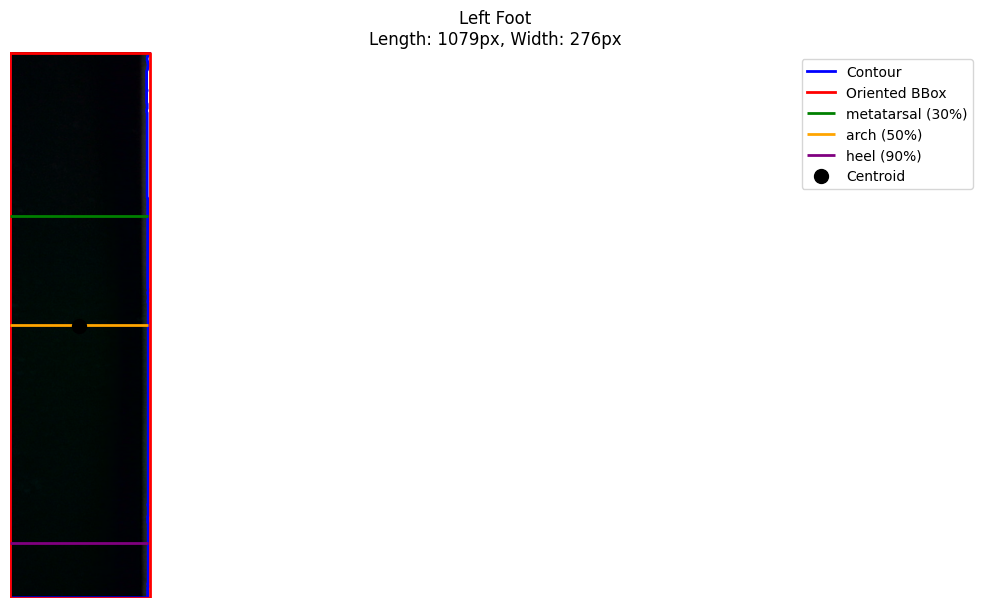

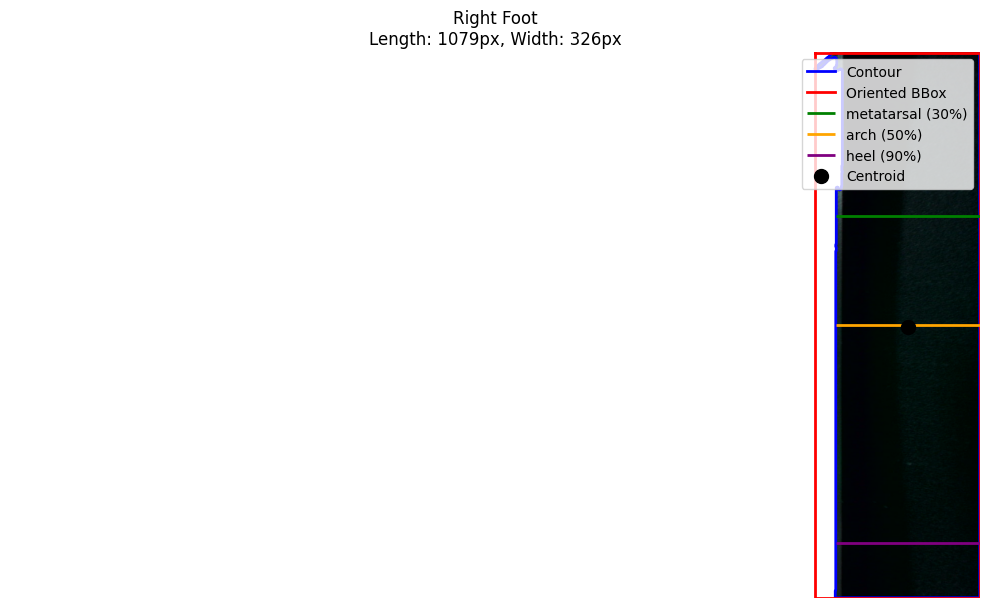

In [8]:
def visualize_measurements(image_rgb, foot_mask, measurements, title="Foot Measurements"):
    """
    Visualize the foot with measurement annotations.
    """
    if measurements is None:
        return
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show foot region only
    display_img = image_rgb.copy()
    display_img[foot_mask == 0] = [255, 255, 255]  # White background
    ax.imshow(display_img)
    
    # Draw contour
    contour = measurements['contour']
    contour_pts = contour.reshape(-1, 2)
    ax.plot(contour_pts[:, 0], contour_pts[:, 1], 'b-', linewidth=2, label='Contour')
    
    # Draw oriented bounding box
    rect = measurements['oriented_rect']
    box = cv.boxPoints(rect)
    box = np.int32(box)
    box_closed = np.vstack([box, box[0]])
    ax.plot(box_closed[:, 0], box_closed[:, 1], 'r-', linewidth=2, label='Oriented BBox')
    
    # Draw width lines at sample positions
    rows_with_foot = np.where(foot_mask.sum(axis=1) > 0)[0]
    if len(rows_with_foot) > 0:
        top_row = rows_with_foot[0]
        bottom_row = rows_with_foot[-1]
        total_height = bottom_row - top_row
        
        positions = {
            'metatarsal (30%)': int(top_row + total_height * 0.30),
            'arch (50%)': int(top_row + total_height * 0.50),
            'heel (90%)': int(top_row + total_height * 0.90)
        }
        
        colors = ['green', 'orange', 'purple']
        for (name, row), color in zip(positions.items(), colors):
            if row < foot_mask.shape[0]:
                cols = np.where(foot_mask[row, :] > 0)[0]
                if len(cols) > 0:
                    ax.hlines(row, cols[0], cols[-1], colors=color, linewidth=2, label=name)
    
    # Add centroid
    cy, cx = measurements['centroid']
    ax.plot(cx, cy, 'ko', markersize=10, label='Centroid')
    
    ax.set_title(f"{title}\nLength: {measurements['foot_length_px']:.0f}px, Width: {measurements['foot_width_px']:.0f}px")
    ax.legend(loc='upper right')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

if left_measurements:
    visualize_measurements(image_rgb, left_foot_mask, left_measurements, "Left Foot")
if right_measurements:
    visualize_measurements(image_rgb, right_foot_mask, right_measurements, "Right Foot")

## 6. Common Podiatric Indices (for future development)

Once you've verified segmentation works, you can add these indices:

- **Staheli Index** = Arch Width / Heel Width
- **Chippaux-Smirak Index** = (Arch Width / Metatarsal Width) × 100
- **Clarke's Angle** - requires finding the tangent line
- **Arch Index** = Arch Area / (Forefoot Area + Midfoot Area + Hindfoot Area)

In [9]:
def calculate_arch_indices(widths):
    """
    Calculate common arch indices from width measurements.
    """
    indices = {}
    
    if 'arch' in widths and 'heel' in widths and widths['heel'] > 0:
        # Staheli Index: Normal 0.3-0.5, Flat foot > 0.7
        indices['staheli'] = widths['arch'] / widths['heel']
    
    if 'arch' in widths and 'metatarsal' in widths and widths['metatarsal'] > 0:
        # Chippaux-Smirak Index: Normal 25-45%, Flat foot > 50%
        indices['chippaux_smirak'] = (widths['arch'] / widths['metatarsal']) * 100
    
    return indices

if left_measurements:
    left_indices = calculate_arch_indices(left_measurements['widths_at_positions'])
    print("Left Foot Indices:")
    for name, value in left_indices.items():
        print(f"  {name}: {value:.2f}")

if right_measurements:
    right_indices = calculate_arch_indices(right_measurements['widths_at_positions'])
    print("\nRight Foot Indices:")
    for name, value in right_indices.items():
        print(f"  {name}: {value:.2f}")

Left Foot Indices:
  staheli: 1.00
  chippaux_smirak: 100.37

Right Foot Indices:
  staheli: 1.00
  chippaux_smirak: 100.35


## 7. Batch Processing (for multiple images)

In [10]:
def process_plantogram(image_path, segmentation_method='otsu'):
    """
    Complete pipeline: load image -> segment -> split feet -> measure.
    
    Returns dict with all measurements for both feet.
    """
    image = cv.imread(image_path)
    if image is None:
        return None
    
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    # Segment
    if segmentation_method == 'otsu':
        mask = segment_foot_otsu(image_rgb)
    else:
        mask = segment_foot_hsv(image_rgb)
    
    # Split feet
    left_mask, right_mask = split_feet(mask)
    
    # Measure
    results = {
        'image_path': image_path,
        'left_foot': calculate_foot_measurements(left_mask),
        'right_foot': calculate_foot_measurements(right_mask)
    }
    
    return results

# Example: process all images in folder
plantogram_folder = "/home/dima/Documents/альбрехт/обработка изображений/плантограммы/"

all_results = []
for filename in os.listdir(plantogram_folder):
    if filename.endswith('.png'):
        filepath = os.path.join(plantogram_folder, filename)
        result = process_plantogram(filepath)
        if result:
            all_results.append(result)
            print(f"Processed: {filename}")

print(f"\nTotal images processed: {len(all_results)}")

Otsu threshold value: 90.0
Processed: Img (copy 7).png
Otsu threshold value: 103.0
Processed: Img.png
Otsu threshold value: 100.0
Processed: Img (copy 8).png
Otsu threshold value: 111.0
Processed: Img (copy 13).png
Otsu threshold value: 96.0
Processed: Img (copy 10).png
Otsu threshold value: 95.0
Processed: Img (copy 11).png
Otsu threshold value: 114.0
Processed: Img (copy 1).png
Otsu threshold value: 97.0
Processed: Img (copy 4).png
Otsu threshold value: 98.0
Processed: Img (copy 9).png
Otsu threshold value: 109.0
Processed: Img (copy 3).png
Otsu threshold value: 112.0
Processed: Img (copy 14).png
Otsu threshold value: 95.0
Processed: Img (copy 12).png
Otsu threshold value: 95.0
Processed: Img (copy 6).png
Otsu threshold value: 114.0
Processed: Img (copy 2).png
Otsu threshold value: 98.0
Processed: Img (copy 5).png

Total images processed: 15
